# Imports

In [1]:
import numpy as np
from scipy.stats import ttest_ind

from khan_helpers import Experiment
from khan_helpers.constants import (
    CORRECT_ANSWER_COLOR, 
    FIG_DIR, 
    INCORRECT_ANSWER_COLOR
)
from khan_helpers.functions import (
    bootstrap_ci_plot, 
    corr_mean, 
    filter_nan_warnings, 
    r2z, 
    reconstruct_trace, 
    show_source, 
    z2r
)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Experiment & Participant classes, helper functions, and variables used across multiple notebooks can be found in `/mnt/code/khan_helpers/khan_helpers`, or on GitHub, [here](https://github.com/contextlab/efficient-learning-khan/tree/master/code/khan_helpers).<br />You can also view source code directly from the notebook with:<br /><pre>    from khan_helpers.functions import show_source<br />    show_source(foo)</pre>

# Inspect & define some helper functions

In [2]:
show_source(r2z)

In [3]:
show_source(z2r)

In [4]:
show_source(corr_mean)

In [5]:
show_source(filter_nan_warnings)

In [6]:
show_source(bootstrap_ci_plot)

In [7]:
def format_stats(stat, p, stat_name, df=None):
    stat_fmt = fr'${stat_name}$'
    if df is not None:
        stat_fmt = f'{stat_fmt}({df})'
    
    stat_fmt = f'{stat_fmt} = {stat:.3f}\n$p$'
    if p < 0.001:
        p_fmt = ' < 0.001'
    else:
        p_fmt = f' = {p:.3f}'
    
    return f'{stat_fmt}{p_fmt}'

# Run "leave one question out" analyses

In [8]:
exp = Experiment()

In [9]:
# questions x questions correlation matrix
questions_corrmat = np.corrcoef(exp.question_vectors)

# n-quizzes x n-participants x n-quiz-questions-minus-1 arrays
correct_rank_corrmeans = np.full((3, len(exp.participants), 12), np.nan)
incorrect_rank_corrmeans = np.full_like(correct_rank_corrmeans, np.nan)

for quiz in range(1, 4):
    for ix, p in enumerate(exp.participants):
        quiz_data = p.get_data(quiz=quiz-1)
        
        # correctly answered questions first:
        correct_question_data = quiz_data.query('accuracy == 1')
        
        # participant must have correctly answered at least 2 quiz 
        # questions to include in leave-one-out analysis
        # (Note: all participants did so on all 3 quizzes)
        if len(correct_question_data) > 1:
            # indices of correctly answered questions in questions x 
            # topics matrix & questions x questions correlation matrix
            correct_qs_ixs = correct_question_data['qID'].to_numpy() - 1
            # n-correct-questions x n-correct-questions correlation matrix
            correct_qs_corrmat = questions_corrmat[correct_qs_ixs, 
                                                   correct_qs_ixs[:, None]]
            # sort each row in descending order, drop first column 
            # (always 1 for question's correlation with self). Each row 
            # is now the correlations between a single held-out question 
            # and all *other* correctly answered questions from the same 
            # quiz
            correct_qcorrs_sorted = np.sort(correct_qs_corrmat, axis=1)[:, -2::-1]
            # z-transform, avg each column, inverse z-transform
            correct_rank_mean_corrs = corr_mean(correct_qcorrs_sorted, axis=0)
            # (partially) fill participant's row in matrix from left
            correct_rank_corrmeans[
                quiz-1, ix, :len(correct_rank_mean_corrs)
            ] = correct_rank_mean_corrs

        # now repeat with incorrectly answered questions
        incorrect_question_data = quiz_data.query('accuracy == 0')
        # participant must have incorrectly answered at least 2 
        # questions to include in leave-one-out analysis
        # (Note: 2 participants got 12/13 or 13/13 correct on quiz 2, 14 
        # got 12/13 or 13/13 correct on quiz 3)
        if len(incorrect_question_data) < 2:
            continue

        incorrect_qs_ixs = incorrect_question_data['qID'].to_numpy() - 1
        incorrect_qs_corrmat = questions_corrmat[incorrect_qs_ixs, 
                                                 incorrect_qs_ixs[:, None]]
        incorrect_qcorrs_sorted = np.sort(incorrect_qs_corrmat, axis=1)[:, -2::-1]
        incorrect_rank_mean_corrs = corr_mean(incorrect_qcorrs_sorted, axis=0)
        incorrect_rank_corrmeans[
            quiz-1, ix, :len(incorrect_rank_mean_corrs)
        ] = incorrect_rank_mean_corrs

In [10]:
knowledge_estimates = {}
for quiz in range(1, 4):
    correct_knowledge_estimates = []
    incorrect_knowledge_estimates = []

    for p in exp.participants:
        quiz_data = p.get_data(quiz=quiz-1)
        
        for ix, heldout_question_data in enumerate(quiz_data.itertuples()):
            if heldout_question_data.qID == 38:
                continue
            
            other_questions_data = quiz_data.drop(index=heldout_question_data.Index)
            heldout_question = exp.question_vectors[heldout_question_data.qID - 1]
            other_questions = exp.question_vectors[other_questions_data['qID'] - 1]
            accuracy = other_questions_data['accuracy']
            knowledge_estimate = reconstruct_trace(heldout_question[None, :], 
                                                   other_questions, 
                                                   accuracy).item()
            if heldout_question_data.accuracy == 1:
                correct_knowledge_estimates.append(knowledge_estimate)
            else:
                incorrect_knowledge_estimates.append(knowledge_estimate)

    knowledge_estimates[f'quiz{quiz}'] = {
        'correct': correct_knowledge_estimates, 
        'incorrect': incorrect_knowledge_estimates
    }

# Construct and display figure

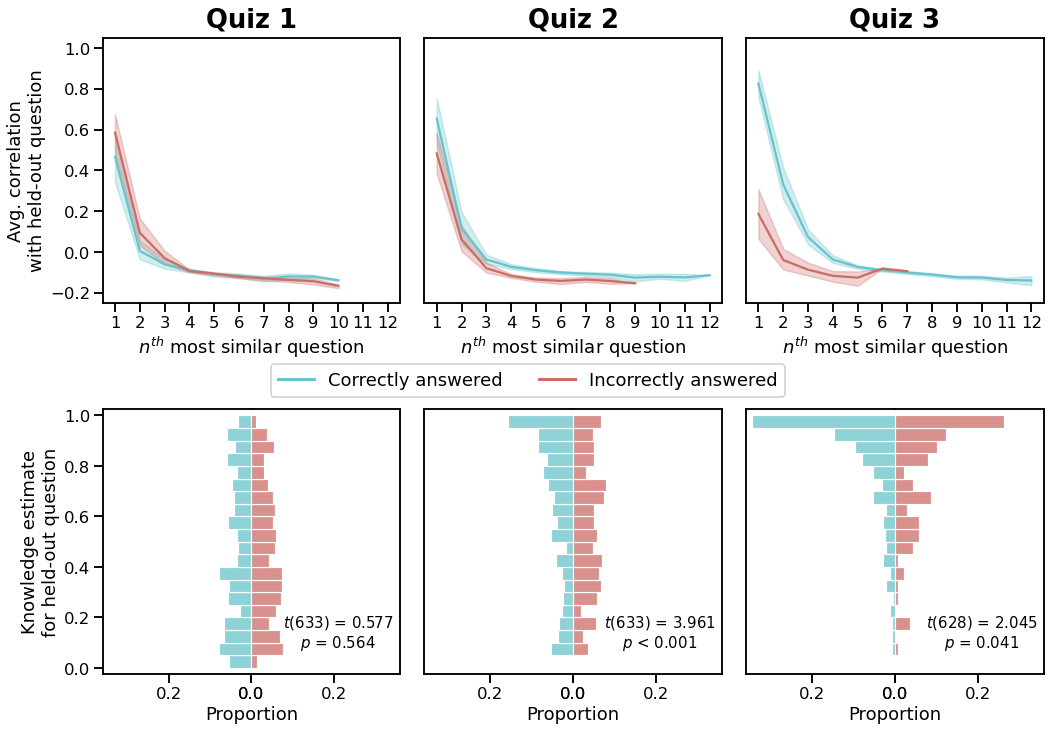

In [11]:
with sns.plotting_context('talk'):
    fig = plt.figure(figsize=(15, 10.5))
    main_gs = fig.add_gridspec(2, 3)
    
    ax1 = fig.add_subplot(main_gs[0, 0])
    ax2 = fig.add_subplot(main_gs[0, 1], sharey=ax1)
    ax3 = fig.add_subplot(main_gs[0, 2], sharey=ax1)
    
    quiz1_gs = main_gs[1, 0].subgridspec(1, 2, wspace=0)
    quiz2_gs = main_gs[1, 1].subgridspec(1, 2, wspace=0)
    quiz3_gs = main_gs[1, 2].subgridspec(1, 2, wspace=0)
    
    ax4 = fig.add_subplot(quiz1_gs[0])
    ax5 = fig.add_subplot(quiz1_gs[1], sharey=ax4)
    ax6 = fig.add_subplot(quiz2_gs[0], sharey=ax4)
    ax7 = fig.add_subplot(quiz2_gs[1], sharey=ax4)
    ax8 = fig.add_subplot(quiz3_gs[0], sharey=ax4)
    ax9 = fig.add_subplot(quiz3_gs[1], sharey=ax4)
    
    top_row_axes = np.array((ax1, ax2, ax3))
    bottom_row_axes = np.array((ax4, ax5, ax6, ax7, ax8, ax9))
    
    ####################### First row of panels ########################
    for quiz, ax in enumerate(top_row_axes, start=1):
        correct_data = correct_rank_corrmeans[quiz-1].T
        incorrect_data = incorrect_rank_corrmeans[quiz-1].T
        
        bootstrap_ci_plot(correct_data, 
                          ignore_nan=True, 
                          color=CORRECT_ANSWER_COLOR, 
                          ax=ax)
        bootstrap_ci_plot(incorrect_data, 
                          ignore_nan=True, 
                          color=INCORRECT_ANSWER_COLOR, 
                          ax=ax)
        
        ax.set_xlim(-0.5, 11.5)
        ax.set_xticks(range(0, 12), labels=range(1, 13))
        ax.set_xlabel('$n^{th}$ most similar question')
        ax.set_ylim(-0.25, 1.05)
        ax.set_title(f'Quiz {quiz}', 
                     y=1.02, 
                     fontsize='x-large', 
                     fontweight='bold')
        
        if quiz > 1:
            ax.tick_params(left=False, labelleft=False)
        
    ax1.set_ylabel('Avg. correlation\nwith held-out question')
    
    ####################### Second row of panels #######################

    bins = np.linspace(0, 1, 21, endpoint=True, dtype=np.float16)
    for quiz, (left_ax, right_ax) in enumerate(bottom_row_axes.reshape(3, 2), 
                                               start=1):
        quiz_estimates = knowledge_estimates[f'quiz{quiz}']
        correct_estimates = quiz_estimates['correct']
        incorrect_estimates = quiz_estimates['incorrect']
        
        t, p = ttest_ind(correct_estimates, incorrect_estimates)
        deg_freedom = len(correct_estimates) + len(incorrect_estimates) - 2
        
        sns.histplot(y=correct_estimates, 
                     bins=bins,
                     stat='proportion',
                     color=CORRECT_ANSWER_COLOR,
                     edgecolor='white',
                     ax=left_ax)
        sns.histplot(y=incorrect_estimates, 
                     bins=bins,
                     stat='proportion',
                     color=INCORRECT_ANSWER_COLOR,
                     edgecolor='white',
                     ax=right_ax)
        
        left_ax.set_xlim(0, 0.36)
        right_ax.set_xlim(0, 0.36)
        
        left_ax.set_xlabel('Proportion', x=1, ha='center')
        right_ax.set_xlabel(None)
        
        left_ax.invert_xaxis()
        
        right_ax.annotate(format_stats(t, p, 't', deg_freedom), 
                          xy=(0.21, 0.08), 
                          fontsize='small',
                          ha='center')

        left_ax.spines['right'].set_visible(False)
        right_ax.spines['left'].set_visible(False)
        
    ax4.set_ylim(-0.025, 1.025)
    ax4.set_ylabel('Knowledge estimate\nfor held-out question')
    
    for ax in bottom_row_axes[1:]:
        ax.tick_params(left=False, labelleft=False)
    
    
    leg = fig.legend(ax2.get_lines(), 
                     ('Correctly answered', 'Incorrectly answered'), 
                     loc='center',
                     ncol=2,
                     fontsize='medium', 
                     frameon=True, framealpha=1, bbox_to_anchor=(0.5, 0.48))
    
    for line in leg.get_lines():
        line.set_linewidth(3)
        
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4)
    plt.savefig(FIG_DIR.joinpath('held-out-question-analyses.pdf'), bbox_inches='tight')
    plt.show()